# DLinear

Ce notebook produit un modele DLinear entrainé pour chaque série et d'évalue sa performance.

Le modele est reconstruit dans pytorch 1.13 compatible avec mon GPU Quadro M620.

l'objectif est :
- tester la performance d'un modèle DLinear sur le probleme de détection des anomalies de consommation
- s'entrainer à l'utilisation de pytorch
- disposer d'un modèle DLinear compatible avec pytorch 1.13

Requirements :
- python==3.10.19
- torch==1.13.1
- numpy==1.24.3
- pandas==2.3.3

## Imports et paramétrages

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F



from sklearn.cluster import KMeans


In [49]:
print(torch.__version__)
print(torch.cuda.get_device_name(0))


1.13.1
Quadro M620


## Chargement et pré_traitement des données

### Chargement

In [50]:
file_path = "./data/"
project_name_eau = "detection_fuite.csv"

print("*** Chargement des données *** \n")
data_eau = pd.read_csv(f"{file_path}/{project_name_eau}")
print(f"Affichage des premières lignes du dataset : \n\n {data_eau.head()} \n\n")
print(f"Dimension du dataset : {data_eau.shape}")

*** Chargement des données *** 

Affichage des premières lignes du dataset : 

    valeur_active valeur_date libelle
0           35.0  2019-01-01    ID_1
1            0.0  2019-01-01    ID_2
2            2.0  2019-01-01    ID_3
3           38.0  2019-01-01    ID_4
4           38.0  2019-01-01    ID_5 


Dimension du dataset : (470900, 3)


In [51]:
# conversion date et tri
data_eau["date"] = pd.to_datetime(data_eau["valeur_date"])
data_eau=data_eau.sort_values(['libelle','date'])

In [52]:
# sélection des dates
start_date = "2022-01-01"
data=data_eau[(data_eau["date"]>=start_date)][['libelle','date','valeur_active']].copy()

### Nettoyage

In [53]:
# retirer valeur négatives ou nulles
data.loc[data['valeur_active']<=0, 'valeur_active'] = np.nan

# retirer les valeurs extrèmes
data.loc[data['valeur_active']>1e3, 'valeur_active']=np.nan

# retirer valeur quasi-nulles et pic
q01 = (
    data.groupby('libelle')['valeur_active']
      .transform(lambda x: x.quantile(0.01))
)

q99 = (
    data.groupby('libelle')['valeur_active']
      .transform(lambda x: x.quantile(0.99))
)
data.loc[(data['valeur_active'] <= q01) | (data['valeur_active'] >= q99), 'valeur_active'] = np.nan

# retirer nan
data = data[data["valeur_active"].notna()].copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334919 entries, 40076 to 470760
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   libelle        334919 non-null  object        
 1   date           334919 non-null  datetime64[ns]
 2   valeur_active  334919 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 10.2+ MB


In [54]:
# retirer les compteurs avec moins de 80% de données
nbre_valeur_par_compteur=(data
    .groupby('libelle')['valeur_active']
    .count())
seuil = 0.8 * nbre_valeur_par_compteur.max()
libelles_volumineux = nbre_valeur_par_compteur[nbre_valeur_par_compteur > seuil].index
data=data[data['libelle'].isin(libelles_volumineux)].copy()

### Clusterisation

In [55]:
moyenne_par_compteur=data.groupby('libelle')['valeur_active'].mean().reset_index()
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(moyenne_par_compteur[['valeur_active']])
labels = kmeans.labels_
centers = kmeans.cluster_centers_
moyenne_par_compteur["cluster"] = labels

In [56]:
cluster_principal = moyenne_par_compteur['cluster'].value_counts().idxmax()
libelles_principaux = moyenne_par_compteur[moyenne_par_compteur['cluster'] == cluster_principal]['libelle']
data=data[data['libelle'].isin(libelles_principaux)].copy()

### Resampling

In [57]:
def resample_and_interpolate(group):
    # Trier par date
    group = group.sort_values('date').set_index('date')
    
    # Resample quotidien uniquement avec moyenne pour doublon
    group_num = group[['valeur_active']].resample('D').mean()
    
    # Interpolation time
    group_num['valeur_active'] = group_num['valeur_active'].interpolate(method='time')
    
    # Remettre libelle
    group_num['libelle'] = group['libelle'].iloc[0]
    
    return group_num

# Appliquer par libelle
#group_keys=False pour que le libelle ne soit pas ajouté comme index supplémentaire
#reset index pour mettre les dates resamplée en colonnes
data_resampled = data.groupby('libelle', group_keys=False).apply(resample_and_interpolate).reset_index()

/tmp/ipykernel_4200/4054849344.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_resampled = data.groupby('libelle', group_keys=False).apply(resample_and_interpolate).reset_index()


### Bilan

In [58]:
print(f"Nombre de compteurs initiaux : {len(data_eau['libelle'].unique())}")
print(f"Nombre de compteurs finaux : {len(data_resampled['libelle'].unique())}")

Nombre de compteurs initiaux : 502
Nombre de compteurs finaux : 183


In [59]:
data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199300 entries, 0 to 199299
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           199300 non-null  datetime64[ns]
 1   valeur_active  199300 non-null  float64       
 2   libelle        199300 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.6+ MB


In [60]:
# fit to Darts.DLinear standard columns name
data_resampled=data_resampled.rename(columns={'date':'ds', 'valeur_active':'y', 'libelle':'unique_id'})

## Création de la classe Dataset

In [61]:
class DLinearDataset(Dataset):
    def __init__(self, df:pd.DataFrame):
        """
        objet dataset pour un modèle DLinear
        Args:
        - df: pd.Dataframe with columns [unique_id, ds, y]
        - transform: Optional transforms to apply to samples
        """
        # Pivot
        df_pivot = df.pivot(index="ds", columns="unique_id", values="y")
        # liste des id_name
        self.id_name = df_pivot.columns.values
        # liste des ds
        self.ds = df_pivot.index.values
        # back and forward fill (dans le temps)
        self.data = df_pivot.sort_index().ffill().bfill().values

    def set_params(self, moving_avg_window:int, windows_batch_size:int, inference_windows_batch_size:int):
        '''
        Definit les paramètres du DLinear. A appeler avant la création du dataloader.
        Permet de modifier les paramètres sans recréer un objet DLinearDataset
        args :
        - moving_avg_window : int taille de la fenetre de moyenne mobile pour le calcul de trend
        - windows_batch_size : int taille de la fenetre de backcast
        - inference_windows_batch_size : int taille de la fenetre de forecast
        '''
        self.moving_avg_window=moving_avg_window
        self.windows_batch_size=windows_batch_size
        self.inference_windows_batch_size=inference_windows_batch_size
        self.total_window = moving_avg_window + windows_batch_size + inference_windows_batch_size - 1

        ###SECURITE###
        # parametre window >= 1
        assert self.moving_avg_window >=1, "moving_avg_window must be greater or equal 1"
        assert self.windows_batch_size >=1, "windows_batch_size must be greater or equal 1"
        assert self.inference_windows_batch_size >=1, "inference_windows_batch_size must be greater or equal 1"
        assert len(self) >= 1, "taille de série insuffisante"

        return self

    def __len__(self):
        """
        Return the total number of samples
        used by the data loader
        """
        # indice de 0 à self.data.shape[0]-self.total_window 
        return self.data.shape[0]-self.total_window +1

    def __getitem__(self, idx):
        """
        Fetch a single sample by index.
        This is called by DataLoader to build batches.
        """
        # indice de 0 à self.data.shape[0]-self.total_window 
        assert idx <= self.data.shape[0]-self.total_window, "indice trog grand"

        # Extract features and labels
        features = self.data[idx:idx+self.moving_avg_window+self.windows_batch_size-1, :].T
        labels = self.data[idx+self.moving_avg_window+self.windows_batch_size-1:idx+self.total_window, :].T
        # convert into tensor
        features = torch.tensor(features)
        labels = torch.tensor(labels)
        # Apply transforms if provided
        
        return features, labels
    
    def get_date(self,idx):
        '''
        return a dict of the date range for idx
        '''
        # indice de 0 à self.data.shape[0]-self.total_window 
        assert idx <= self.data.shape[0]-self.total_window, "indice trog grand"

        return {'moving_avg_window' : self.ds[idx:idx+self.moving_avg_window],
        'windows_batch_size':self.ds[idx+self.moving_avg_window:idx+self.moving_avg_window+self.windows_batch_size-1],
        'input_window':self.ds[idx:idx+self.moving_avg_window+self.windows_batch_size-1],
        'inference_windows_batch_size':self.ds[idx+self.moving_avg_window+self.windows_batch_size-1:idx+self.total_window],
        'total_window':self.ds[idx:idx+self.total_window],}

In [ ]:
# création du dataset
DLDS=DLinearDataset(data_resampled)

## Création de la classe DLinear

In [ ]:


class DLinearWithSeriesNorm(nn.Module):
    """
    DLinear avec normalisation par série intégrée.
    Args:
        - moving_avg_window : int taille de la fenetre de moyenne mobile pour le calcul de trend
        - windows_batch_size : int taille de la fenetre de backcast
        - inference_windows_batch_size : int taille de la fenetre de forecast

    Input shape : [Batch, Channels, windows_batch_size]
    Output shape : [Batch, Channels, pred_len, inference_windows_batch_size]
    """
    def __init__(self, moving_avg_window:int, windows_batch_size:int, inference_windows_batch_size:int):
        super().__init__()

        self.moving_avg_window=moving_avg_window
        self.windows_batch_size=windows_batch_size
        self.inference_windows_batch_size=inference_windows_batch_size

        # création des deux modeles linéaires
        self.linear_trend = nn.Linear(self.windows_batch_size, self.inference_windows_batch_size)
        self.linear_seasonal = nn.Linear(self.windows_batch_size, self.inference_windows_batch_size)

        ###SECURITE###
        # parametre window >= 1
        assert self.moving_avg_window >=1, "moving_avg_window must be greater or equal 1"
        assert self.windows_batch_size >=1, "windows_batch_size must be greater or equal 1"
        assert self.inference_windows_batch_size >=1, "inference_windows_batch_size must be greater or equal 1"
        assert self.moving_avg_window%2 ==1, "moving_avg_window must odd"

    def forward(self, x):
        """
        x: [B, C, W] avec W = moving_avg_window + windows_batch_size - 1
        """
        # --- Normalisation par série ---
        # mean/std sur la dimension temporelle wbs
        mean = x.mean(dim=2, keepdim=True)
        std = x.std(dim=2, keepdim=True) + 1e-5  # éviter division par 0
        xn = (x - mean) / std 

        # --- Décomposition trend et season ---
        # moyenne mobile = convolution par canal
        B, C, wbs = x.shape
        kernel = torch.ones(C, 1, self.moving_avg_window, device=x.device, dtype=x.dtype) / self.moving_avg_window   # [C, 1, maw]
        # F.conv1d prend des poids de shape [out_channels, in_channels, kernel_size]
        trend = F.conv1d(x, kernel, groups=C)  # groups=C pour appliquer canal par canal
        # trend aura pour shape : [B, C, W - maw + 1] c'est à dire [B, C, wbs]

        # Décomposition simple en tronquant x équitablement à droite et à gauche
        season = x[:, :, (self.moving_avg_window-1)//2 : - (self.moving_avg_window-1)//2] - trend
        
        # cast
        trend = trend.to(self.linear_trend.weight.dtype)
        season = season.to(self.linear_seasonal.weight.dtype)

        # --- Linear calculation and final addition ---
        # Linéaires independent par canal
        trend_out = self.linear_trend(trend)                  # [B, C, wbs]
        season_out = self.linear_seasonal(season)             # [B, C, wbs]

        y_norm = trend_out + season_out                       # [B, C, iwbs]
        
        # --- Dénormalisation ---
        y = y_norm * std + mean

        return y

## Paramétrage

params : test_RMSE after 100 epoch

7,30, 15 : 7.1

21,40,15 : 7.6

7, 20,15 : 7.0

In [115]:
params={
'moving_avg_window':7,
'windows_batch_size':20,
'inference_windows_batch_size':15,   
'num_epochs':100,
}

## Chargement des données dans le dataset

In [116]:
# set params of dataset
DLDS.set_params(
                params['moving_avg_window'],
                params['windows_batch_size'],
                params['inference_windows_batch_size'],
                )
print(f"taille du dataset : {len(DLDS)}")
features, label = DLDS[0]
print(f"dimensions X : {features.shape}")
print(f"dimensions y : {label.shape}")

taille du dataset : 1056
dimensions X : torch.Size([183, 26])
dimensions y : torch.Size([183, 15])


In [117]:
# Split dataset into train (80%), validation (10%), test (10%)

# Définir les tailles
train_size = int(0.8 * len(DLDS))
val_size = int(0.1 * len(DLDS))
test_size = len(DLDS) - train_size - val_size

# Définir les indices pour chaque split (chronologique)
train_indices = list(range(0, train_size))
val_indices = list(range(train_size, train_size + val_size))
test_indices = list(range(train_size + val_size, len(DLDS)))

# Créer les sous-ensembles
train_dataset = Subset(DLDS, train_indices)
val_dataset = Subset(DLDS, val_indices)
test_dataset = Subset(DLDS, test_indices)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # shuffle ok pour l'entraînement
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)     # pas de shuffle
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)   # pas de shuffle


## Train the model

In [118]:
def evaluate(model, data_loader, criterion, device):
    model.eval()  # mode évaluation
    val_loss = 0.0

    with torch.no_grad():  # pas de gradient pour validation
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            val_loss += loss.item()

    return val_loss / len(data_loader), batch_X.mean().item()

In [119]:
model = DLinearWithSeriesNorm(params['moving_avg_window'],
                            params['windows_batch_size'],
                            params['inference_windows_batch_size'],
                            )
# Setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [120]:
# Training loop
num_epochs = params['num_epochs']

for epoch in range(num_epochs):
    model.train() # Enable training mode
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        # Move data to device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        # 1. Zero the gradients from previous iteration
        optimizer.zero_grad()
        # 2. Forward pass
        outputs = model(batch_X)
        # 3. Compute loss
        loss = criterion(outputs, batch_y)
        # 4. Backward pass (compute gradients)
        loss.backward()
        # 5. Update weights
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    
    # === Validation ===
    avg_val_loss, _ = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train RMSE: {np.sqrt(avg_train_loss):.4f}, "
          f"Val RMSE: {np.sqrt(avg_val_loss):.4f}")

Epoch 1/100, Train RMSE: 219.6488, Val RMSE: 136.6615
Epoch 2/100, Train RMSE: 152.3647, Val RMSE: 101.1799
Epoch 3/100, Train RMSE: 117.5202, Val RMSE: 82.0941
Epoch 4/100, Train RMSE: 98.8465, Val RMSE: 72.6003
Epoch 5/100, Train RMSE: 85.6600, Val RMSE: 65.4662
Epoch 6/100, Train RMSE: 76.9332, Val RMSE: 59.6926
Epoch 7/100, Train RMSE: 68.3395, Val RMSE: 54.9557
Epoch 8/100, Train RMSE: 61.3780, Val RMSE: 50.6136
Epoch 9/100, Train RMSE: 55.2012, Val RMSE: 46.4383
Epoch 10/100, Train RMSE: 49.7472, Val RMSE: 42.5737
Epoch 11/100, Train RMSE: 45.3427, Val RMSE: 39.3041
Epoch 12/100, Train RMSE: 41.3367, Val RMSE: 36.2160
Epoch 13/100, Train RMSE: 36.7329, Val RMSE: 33.4280
Epoch 14/100, Train RMSE: 33.1647, Val RMSE: 31.0910
Epoch 15/100, Train RMSE: 30.2852, Val RMSE: 28.8239
Epoch 16/100, Train RMSE: 27.9885, Val RMSE: 26.8655
Epoch 17/100, Train RMSE: 26.1207, Val RMSE: 25.1015
Epoch 18/100, Train RMSE: 23.9442, Val RMSE: 23.4427
Epoch 19/100, Train RMSE: 22.6821, Val RMSE: 22.05

## Evaluate the model

In [121]:
avg_test_loss, avg = evaluate(model, test_loader, criterion, device)

print(f"Test RMSE : {np.sqrt(avg_test_loss):.1f}",
f"Test Moyenne : {avg:.1f}",
sep='\n',
)

Test RMSE : 7.0
Test Moyenne : 12.1


In [122]:
def impression(unique_id:int, horizon:int=365, model=model, dataset=DLDS):
    '''
    Plot sur un horizon les données Truth et la prédiction pour le libelle d'index unique_id
    encadre la fenetre de backcast
    '''
    assert horizon > dataset.total_window, "L'horizon doit etre supérieur à la fenetre d'inférence du modèle"

    # Récupérer le device du model
    device = next(model.parameters()).device

    # Récupérer le nom du libelle spécifique
    libelle_name=dataset.id_name[unique_id]

    # récupération du signal original
    data = dataset.data[:,unique_id]
    N=dataset.moving_avg_window
    trend=np.convolve(data, np.ones(N)/N, mode='same')
    seasonal = data-trend

    df=pd.DataFrame({'Truth':data, 'Trend':trend, 'Seasonal':seasonal}, index=dataset.ds).iloc[-horizon:]

    # Inférence sur la fin de courbe
    last_idx = len(dataset) - 1 # dernier indice du dataset
    data, label = dataset[last_idx]  # récupère le dernier élément
    dates_dict=dataset.get_date(last_idx)

    input_tensor = data.unsqueeze(0).to(device)  # ajout dimension Batch, shape [1, C, W]
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
    y_pred = output[0, unique_id].cpu().numpy()

    
    df_pred=pd.DataFrame(y_pred, index=dates_dict['inference_windows_batch_size'], columns=['Pred'])
    mask = ~np.isin(df.index,dates_dict['windows_batch_size'])
    df.loc[mask,['Trend','Seasonal']]=np.nan

    #--impression--
    # figure
    plt.figure(figsize=(8, 4))
    pd.concat([df, df_pred], axis=1).plot()

    # Ajouter les traits verticaux de la fenetre de backcast
    d1 = dates_dict['windows_batch_size'][0]
    d2 = dates_dict['windows_batch_size'][-1]
    plt.axvline(d1, color='red', linestyle='--', linewidth=1)
    plt.axvline(d2, color='red', linestyle='--', linewidth=1)

    # Texte
    plt.title(f"Prédicition {libelle_name}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    print(
        f"Taille de la fenêtre de Moyenne mobile : {dataset.moving_avg_window}",
        f"Taille de la fenêtre d'Input :{dataset.windows_batch_size}",
        f"Taille de la fenêtre d'Output :{dataset.inference_windows_batch_size}",
        f"Taille de la fenêtre Totale :{dataset.total_window}",
        sep='\n',
        )

<Figure size 800x400 with 0 Axes>

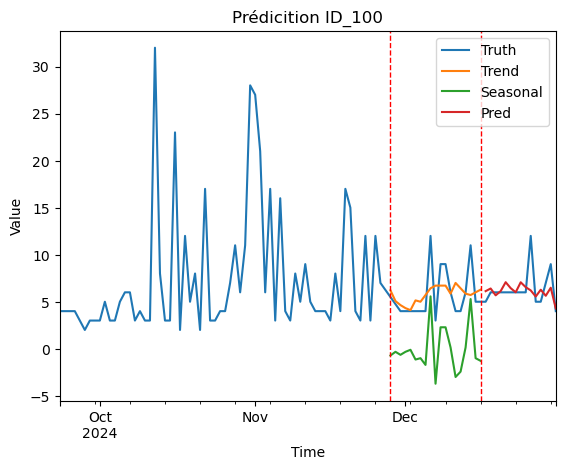

Taille de la fenêtre de Moyenne mobile : 7
Taille de la fenêtre d'Input :20
Taille de la fenêtre d'Output :15
Taille de la fenêtre Totale :41


In [123]:
impression(2,100)